In [9]:
from gorgo import infer, condition, draw_from, flip, keep_deterministic, mem, factor
from gorgo.hashable import hashabledict
from gorgo.distributions.builtin_dists import Uniform, Beta
from gorgo.distributions import Mixture

from model import Utterance, Instance, Kind, meaning, literal_listener, speaker, pragmatic_listener

import numpy as np
from gorgo.inference import MaximumMarginalAPosteriori
import pickle

from collections import namedtuple
import math
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

from scipy.stats import pearsonr

In [10]:
# helper functions
## convert gorgo dist to df for plotting
@keep_deterministic
def dist_to_df(dist):
    df_dist = pd.DataFrame()
    if isinstance(dist.support[0], float): 
        df_dist['Element'] = pd.DataFrame(dist.support)
    else: # df can't support multiple keys
        df_dist = pd.DataFrame(dist.support)
    df_dist['Probability'] = dist.probabilities
    return df_dist

# Study 6

In [11]:
# conditions
conditions = ("generic", "baseline", "specific")

# training trials per condition
generic_condition = (
    (Utterance("Zarpies", "love to eat flowers"), Instance("Zarpie", ("love to eat flowers", ))),
    (Utterance("Zarpies", "have stripes in their hair"), Instance("Zarpie", ("have stripes in their hair", ))),
    (Utterance("Zarpies", "can bounce a ball on their heads"), Instance("Zarpie", ("can bounce a ball on their heads", ))),
    (Utterance("Zarpies", "like to sing"), Instance("Zarpie", ("like to sing", ))),
    (Utterance("Zarpies", "climb tall fences"), Instance("Zarpie", ("climb tall fences", ))),
    (Utterance("Zarpies", "flap their arms when they are happy"), Instance("Zarpie", ("flap their arms when they are happy", ))),
    (Utterance("Zarpies", "have freckles on their feet"), Instance("Zarpie", ("have freckles on their feet", ))),
    (Utterance("Zarpies", "hop over puddles"), Instance("Zarpie", ("hop over puddles", ))),
    (Utterance("Zarpies", "hate walking in the mud"), Instance("Zarpie", ("hate walking in the mud", ))),
    (Utterance("Zarpies", "draw stars on their knees"), Instance("Zarpie", ("draw stars on their knees", ))),
    (Utterance("Zarpies", "can flip in the air"), Instance("Zarpie", ("can flip in the air", ))),
    (Utterance("Zarpies", "are scared of ladybugs"), Instance("Zarpie", ("are scared of ladybugs", ))),
    (Utterance("Zarpies", "hate ice cream"), Instance("Zarpie", ("hate ice cream", ))),
    (Utterance("Zarpies", "chase shadows"), Instance("Zarpie", ("chase shadows", ))),
    (Utterance("Zarpies", "babies are wrapped in orange blankets"), Instance("Zarpie", ("babies are wrapped in orange blankets", ))),
    (Utterance("Zarpies", "sleep in tall trees"), Instance("Zarpie", ("sleep in tall trees", )))
)

specific_condition = (
    (Utterance("This Zarpie", "love to eat flowers"), Instance("Zarpie", ("love to eat flowers", ))),
    (Utterance("This Zarpie", "have stripes in their hair"), Instance("Zarpie", ("have stripes in their hair", ))),
    (Utterance("This Zarpie", "can bounce a ball on their heads"), Instance("Zarpie", ("can bounce a ball on their heads", ))),
    (Utterance("This Zarpie", "like to sing"), Instance("Zarpie", ("like to sing", ))),
    (Utterance("This Zarpie", "climb tall fences"), Instance("Zarpie", ("climb tall fences", ))),
    (Utterance("This Zarpie", "flap their arms when they are happy"), Instance("Zarpie", ("flap their arms when they are happy", ))),
    (Utterance("This Zarpie", "have freckles on their feet"), Instance("Zarpie", ("have freckles on their feet", ))),
    (Utterance("This Zarpie", "hop over puddles"), Instance("Zarpie", ("hop over puddles", ))),
    (Utterance("This Zarpie", "hate walking in the mud"), Instance("Zarpie", ("hate walking in the mud", ))),
    (Utterance("This Zarpie", "draw stars on their knees"), Instance("Zarpie", ("draw stars on their knees", ))),
    (Utterance("This Zarpie", "can flip in the air"), Instance("Zarpie", ("can flip in the air", ))),
    (Utterance("This Zarpie", "are scared of ladybugs"), Instance("Zarpie", ("are scared of ladybugs", ))),
    (Utterance("This Zarpie", "hate ice cream"), Instance("Zarpie", ("hate ice cream", ))),
    (Utterance("This Zarpie", "chase shadows"), Instance("Zarpie", ("chase shadows", ))),
    (Utterance("This Zarpie", "babies are wrapped in orange blankets"), Instance("Zarpie", ("babies are wrapped in orange blankets", ))),
    (Utterance("This Zarpie", "sleep in tall trees"), Instance("Zarpie", ("sleep in tall trees", )))
)

baseline_condition = ()

# scale up for paper figures
sns.set_context("paper", font_scale=1.5)
                # rc={"font.size":20,
                #              "axes.titlesize":20,
                #              "axes.labelsize":20})   

# condition colors for plotting
condition_colors = {'generic': 'tab:orange', 
                    'baseline': 'tab:green',
                    'specific': 'tab:blue'}

# test feature labels for plotting
feature_labels = {
    'live_caves': 'live in caves',
    'ride_lions': 'ride lions',
    'farm_potatoes': 'farm potatoes',
    'play_banjo': 'play banjos',
    'look_left': 'look to their left when spoken to',
    'clap_three': 'clap three times before entering a room',
    'smile_sad': 'smile when they are sad',
    'chug_syrup': 'chug maple syrup',
    'yell_cats': 'yell at stray cats',
    'go_opera': 'go to the opera',
    'dance_fire': 'dance around a fire on their 10th birthday',
    'sing_songs': 'sing beautiful songs',
    'scream_windows': 'scream out windows',
    'smell_garbage': 'smell garbage for fun',
    'wash_ponds': 'wash their clothes in ponds',
    'paint_hands': 'paint their hands yellow'
}

## Model predictions

In [12]:
# # fix inverse temperature at something reasonable, to reduce number of parameters to estimate
# inv_temp = 20

# # get fixed coherence dists
# dist_coherence_generic = pragmatic_listener(
#     generic_condition, 
#     inv_temp = inv_temp,
#     only_return_coherence = True)

# dist_coherence_specific = pragmatic_listener(
#     specific_condition, 
#     inv_temp = inv_temp,
#     only_return_coherence = True)

# dist_coherence_baseline = pragmatic_listener(
#     baseline_condition, 
#     inv_temp = inv_temp,
#     only_return_coherence = True)

# # store output so we don't have to re-run pragmatic listener each time
# with open("scratch/dist_coherence_generic.pkl", "wb") as f:
#     pickle.dump(dist_coherence_generic, f)

# with open("scratch/dist_coherence_specific.pkl", "wb") as f:
#     pickle.dump(dist_coherence_specific, f)

# with open("scratch/dist_coherence_baseline.pkl", "wb") as f:
#     pickle.dump(dist_coherence_baseline, f)

In [13]:
# load model coherence outputs
with open("scratch/dist_coherence_generic.pkl", "rb") as f: 
    dist_coherence_generic = pickle.load(f)

with open("scratch/dist_coherence_specific.pkl", "rb") as f:
    dist_coherence_specific = pickle.load(f)

with open("scratch/dist_coherence_baseline.pkl", "rb") as f:
    dist_coherence_baseline = pickle.load(f)

,Element,Probability
0,0.1,4.65e-16
1,0.3,1.99e-08
2,0.7,0.015
3,0.9,0.854
4,0.6,0.001
5,0.8,0.130
6,0.5,7.04e-05
7,0.2,3.03e-11
8,0.4,1.98e-06


In [14]:
# get coherence distribution by condition
coherence_condition = pd.DataFrame()

df = dist_to_df(dist_coherence_generic)
df["condition"] = "generic"
coherence_condition = pd.concat([df, coherence_condition], ignore_index = True)

df = dist_to_df(dist_coherence_baseline)
df["condition"] = "baseline"
coherence_condition = pd.concat([df, coherence_condition], ignore_index = True)

df = dist_to_df(dist_coherence_specific)
df["condition"] = "specific"
coherence_condition = pd.concat([coherence_condition, df], ignore_index = True)


# get coherence expected value by condition
coherence_condition_ev = pd.DataFrame({
  'condition': ['generic', 'baseline', 'specific'], 
  'coherence_ev': [dist_coherence_generic.expected_value(), 
                   dist_coherence_baseline.expected_value(), 
                   dist_coherence_specific.expected_value()]
})

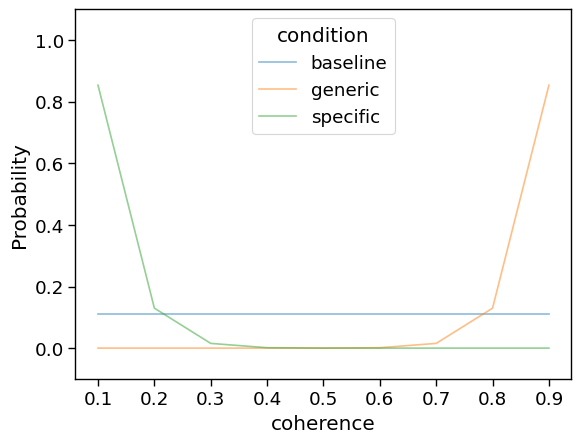

In [48]:
# plot coherence
g = sns.lineplot(data = coherence_condition,
                 hue = "condition", alpha = 0.5, 
                 x = "Element",
                 y = "Probability")
plt.xlabel("coherence")
plt.ylim(-0.1, 1.1)
plt.show(g)

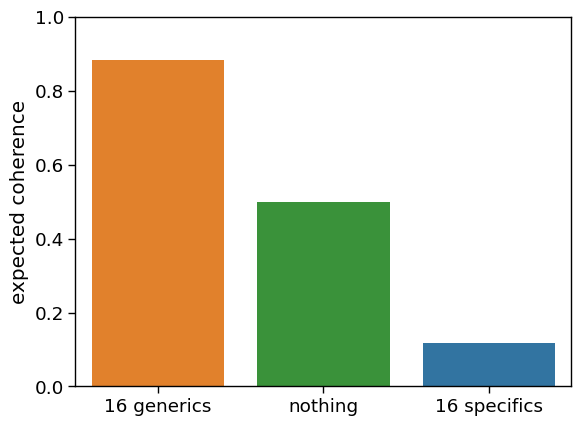

In [ ]:
# plot coherence EV
g = sns.barplot(data = coherence_condition_ev,
                x = 'condition', y = 'coherence_ev',
                hue = 'condition', palette = condition_colors)
plt.xlabel("")
plt.xticks(ticks=['generic', 'baseline', 'specific'],
           labels=['16 generics', 'nothing', '16 specifics'])
plt.ylabel("expected coherence")
plt.ylim(0, 1)
plt.savefig("figs/study 6/predictions_coherence.png", bbox_inches = "tight")
plt.show(g)

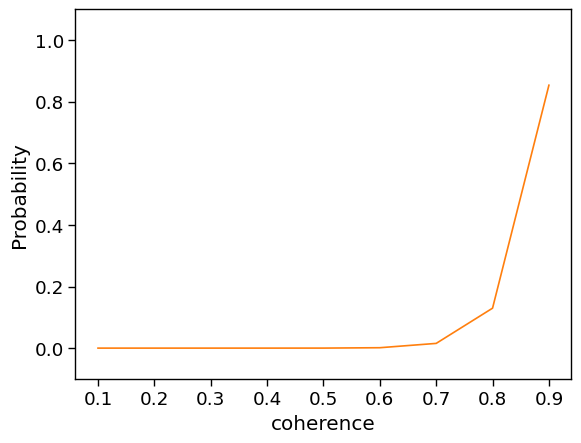

In [47]:
# plot coherence
g = sns.lineplot(data = dist_to_df(dist_coherence_generic),
                 color = condition_colors['generic'],
                 x = "Element",
                 y = "Probability")
plt.xlabel("coherence")
plt.ylim(-0.1, 1.1)

plt.savefig("figs/study 6/predictions_coherence_generic.png", bbox_inches = "tight")
plt.show(g)

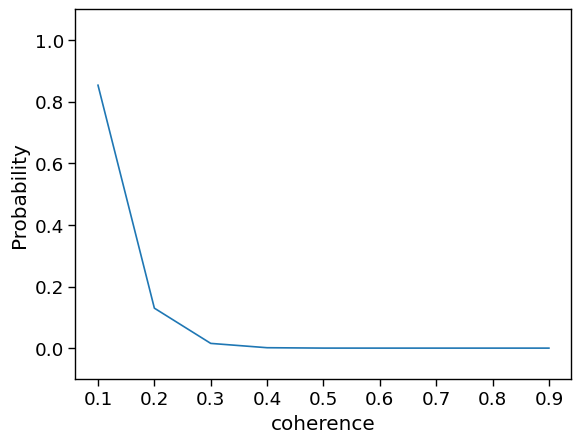

In [46]:
# plot coherence
g = sns.lineplot(data = dist_to_df(dist_coherence_specific),
                 color = condition_colors['specific'],
                 x = "Element",
                 y = "Probability")
plt.xlabel("coherence")
plt.ylim(-0.1, 1.1)

plt.savefig("figs/study 6/predictions_coherence_specific.png", bbox_inches = "tight")
plt.show(g)

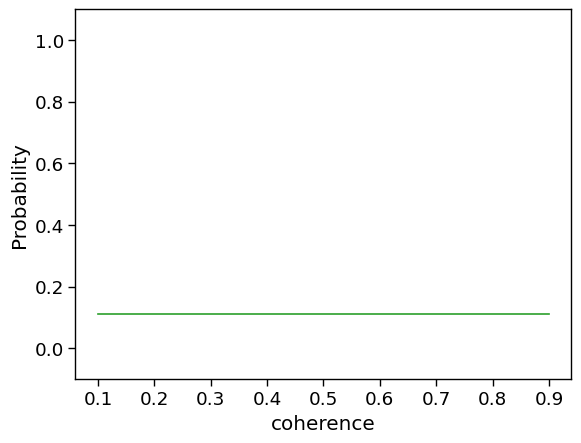

In [45]:
# plot coherence
g = sns.lineplot(data = dist_to_df(dist_coherence_baseline),
                 color = condition_colors['baseline'],
                 x = "Element",
                 y = "Probability")
plt.xlabel("coherence")
plt.ylim(-0.1, 1.1)

plt.savefig("figs/study 6/predictions_coherence_baseline.png", bbox_inches = "tight")
plt.show(g)

## Data

In [20]:
# get observed data
df_raw = pd.read_csv("../data/full_study6.csv")

# select only relevant columns
df_raw = df_raw[["ID", "condition", 
                 "live_caves", "ride_lions", "farm_potatoes", "play_banjo", 
                 "look_left", "clap_three", "smile_sad", "chug_syrup", 
                 "yell_cats", "go_opera", "dance_fire", "sing_songs",
                 "scream_windows", "smell_garbage", "wash_ponds", "paint_hands"]]

# tidy data
df_tidy = pd.melt(df_raw,
                  id_vars = ["ID", "condition"], # do *not* tidy these
                  var_name = "feature", value_name = "prevalence")

# order condition
df_tidy['condition'] = df_tidy['condition'].astype(pd.CategoricalDtype(categories=["generic", "baseline", "specific"],
                                                                       ordered=True))

# convert prevalence to 0-1
df_tidy["prevalence"] = df_tidy["prevalence"].div(100)

# clip prevalence to .01-.99, because the non-uniform beta distribution does not include endpoints
df_tidy["prevalence"] = df_tidy["prevalence"].replace(1, .99)
df_tidy["prevalence"] = df_tidy["prevalence"].replace(0, .01)

# get all test features
all_test_features = df_tidy["feature"].unique()

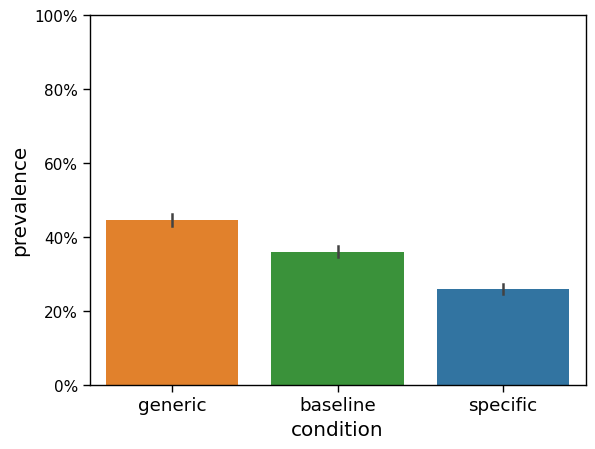

In [21]:
# plot prevalence
g = sns.barplot(data = df_tidy,
                x = 'condition', y = 'prevalence',
                hue = 'condition', palette = condition_colors)
# y-axis percentage 0-1
plt.ylim(0, 1)
g.yaxis.set_major_formatter(PercentFormatter(1))
g.yaxis.set_tick_params(labelsize = 11)

plt.savefig("figs/study 6/data_condition.png", bbox_inches = "tight")
plt.show(g)

/var/folders/5p/8m9jqqdd581dvm8wc358jtz40000gp/T/ipykernel_37924/3683579716.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([feature_labels[x.get_text()] for x in g.get_xticklabels()])


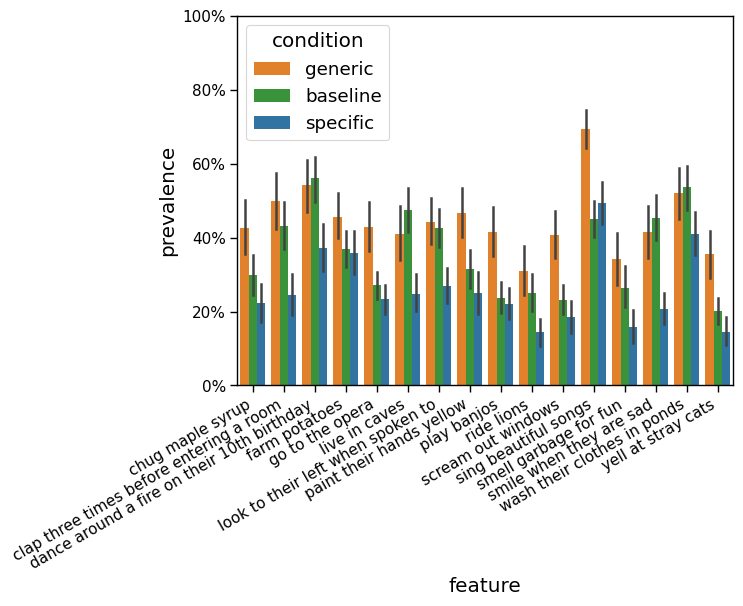

In [22]:
# plot prevalence
g = sns.barplot(data = df_tidy,
                x = 'feature', order=sorted(df_tidy['feature']), # features in alphabetical order
                y = 'prevalence',
                hue = 'condition', palette = condition_colors)
# y-axis percentage 0-1
plt.ylim(0, 1)
g.yaxis.set_major_formatter(PercentFormatter(1))
g.yaxis.set_tick_params(labelsize = 11)
# x-axis rotated long labels
g.set_xticklabels([feature_labels[x.get_text()] for x in g.get_xticklabels()])
plt.xticks(rotation=30, ha='right')
g.xaxis.set_tick_params(labelsize = 11)

plt.savefig("figs/study 6/data_condition_by_feature.png", bbox_inches = "tight")
plt.show(g)

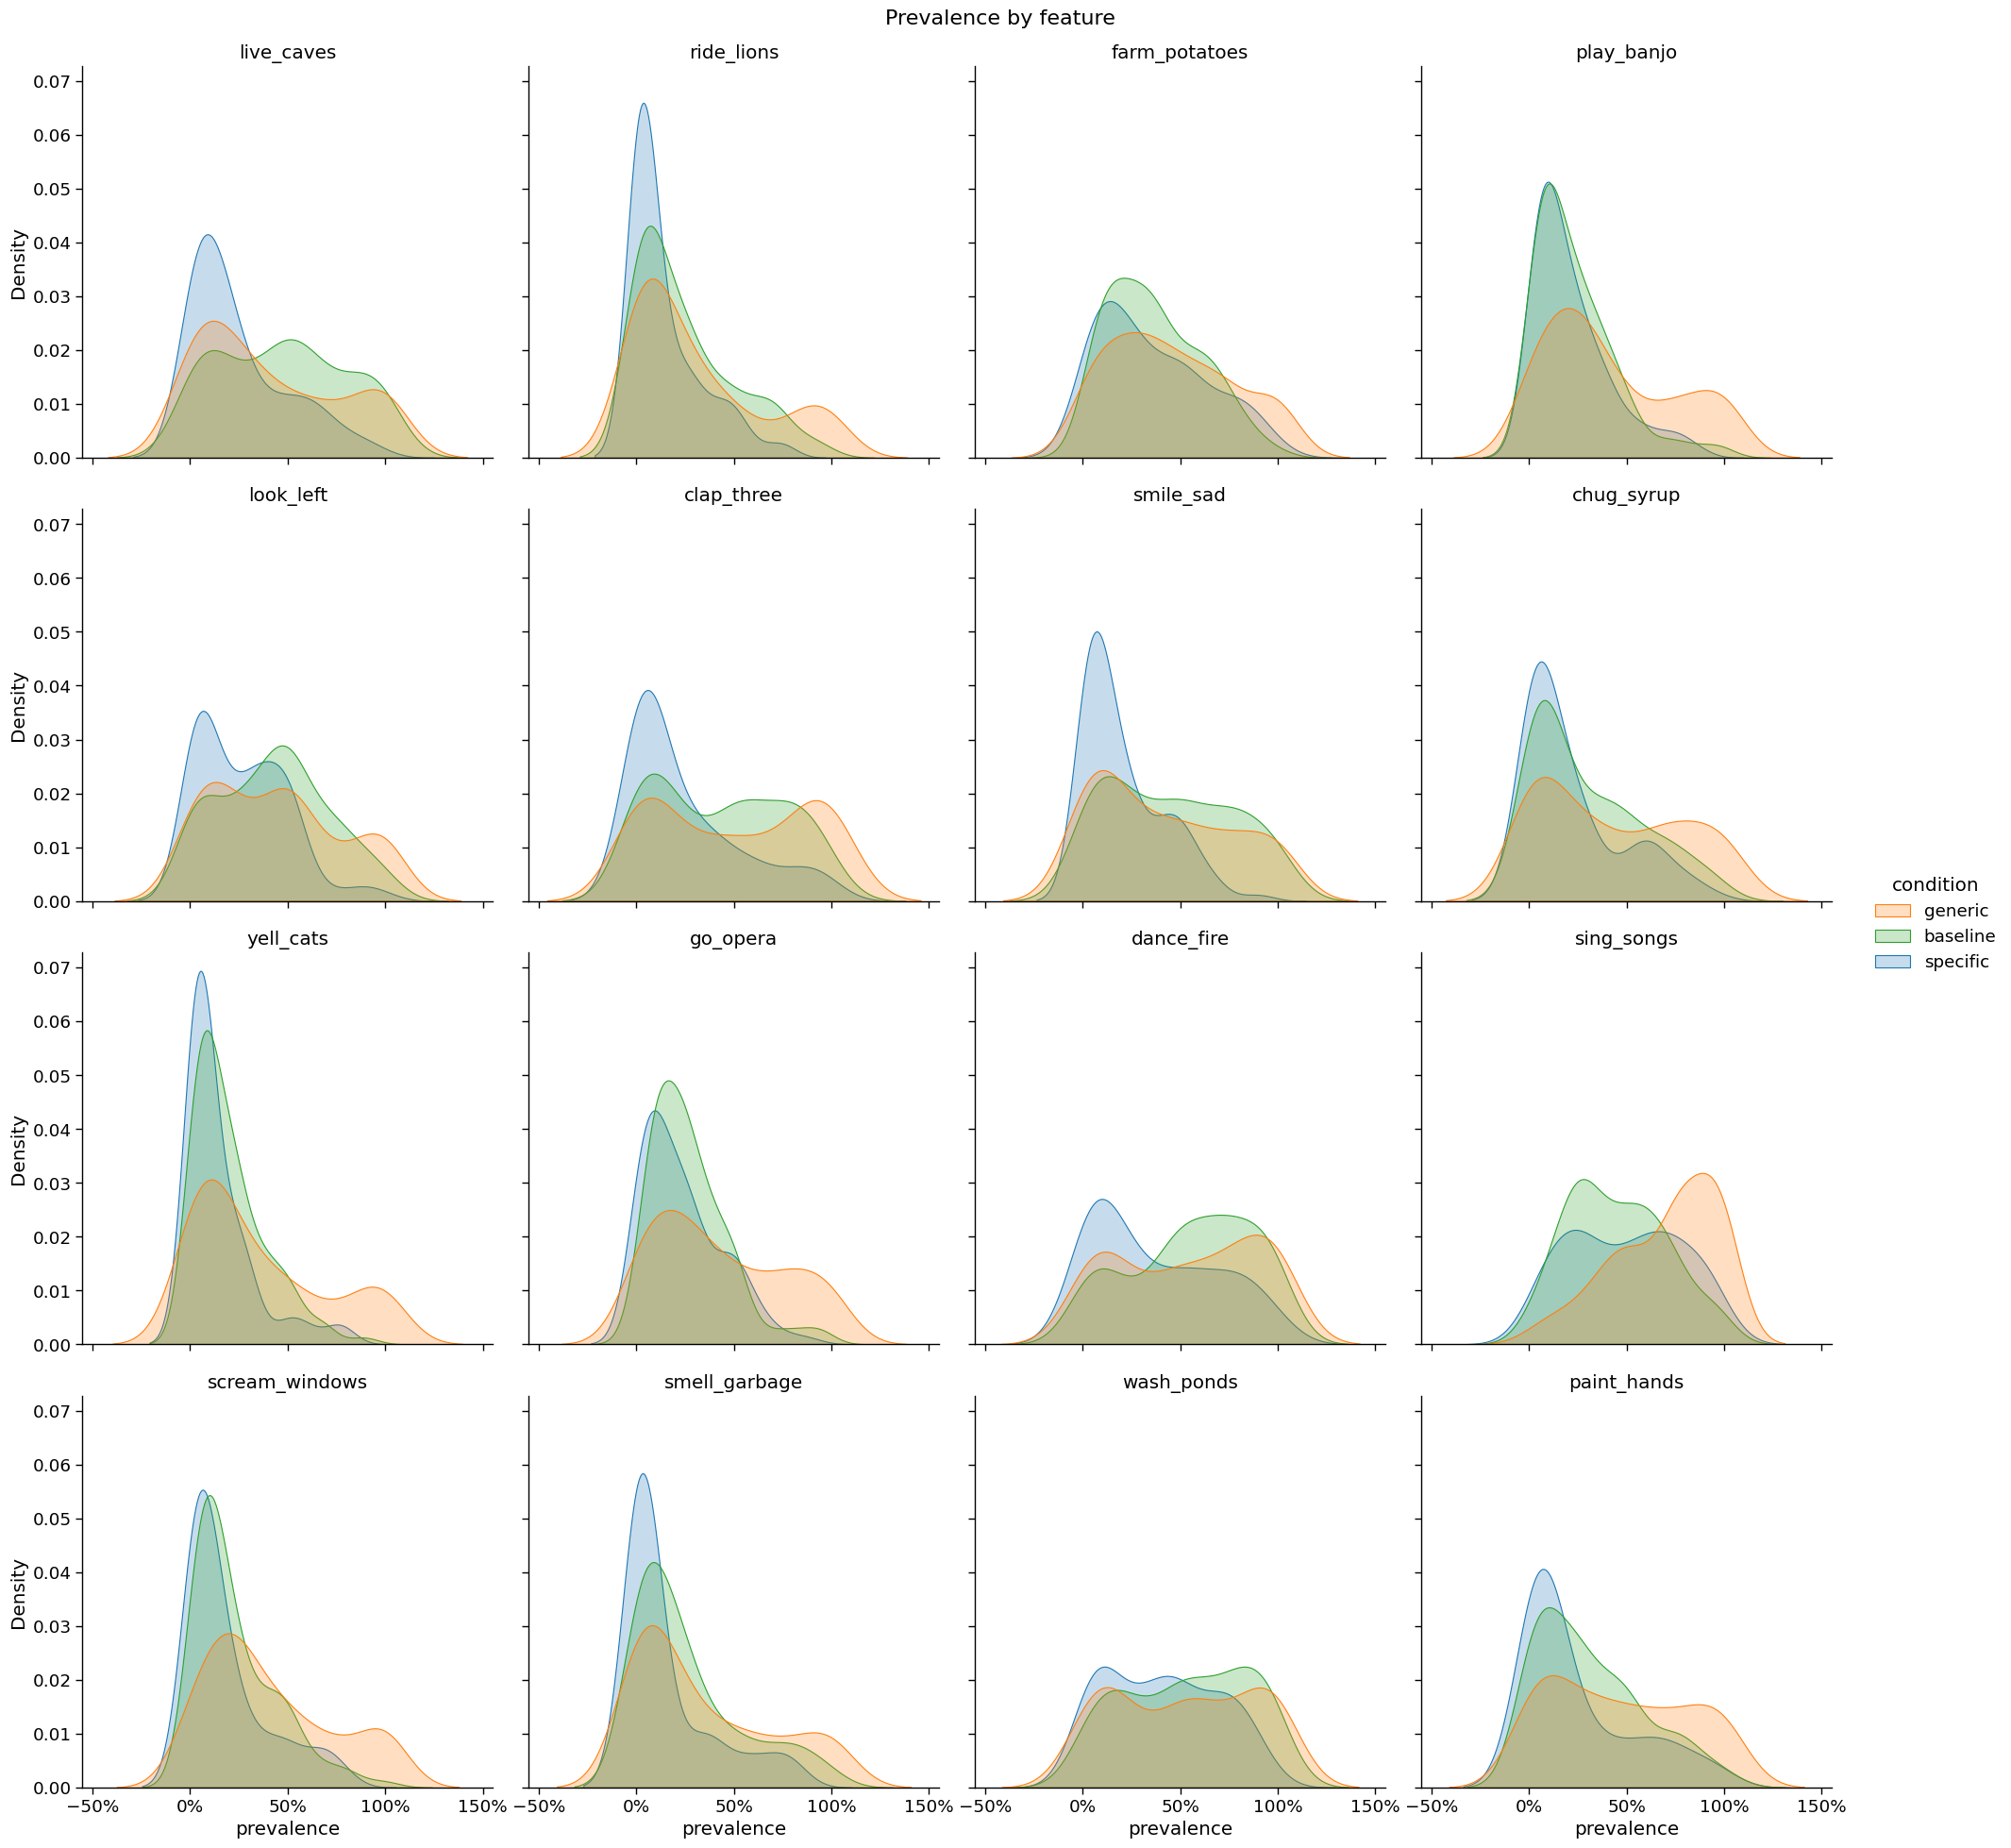

In [28]:
# make plot
g = sns.displot(
    df_tidy, 
    x="prevalence", 
    hue="condition", palette=condition_colors,
    fill=True, 
    col="feature", col_wrap=4,
    multiple="layer",
    kind="kde" # density plot
)
g.fig.suptitle('Prevalence by feature', fontsize=16)
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("figs/study 6/prevalence_by_feature.png", bbox_inches = "tight")

## Model parameter estimation

**MLE (maximum likelihood estimate)**

find the parameters that maximize the likelihood of the data

$$\theta_{\text{MLE}} = \text{max}_\theta p(d|m,\theta)$$

* $p(d|m,\theta)$ = likelihood

We get the MLE for the following parameters from the data:

* **linking function** to provide prevalence estimates for a novel feature $f'$ after observing a new individual $x$ (member of category $k$) with novel feature $f'$. this link generates a prior about the prevalence of the particular feature, which is a mixture of the following beta distributions:

    * **kind-linked distribution**: probability that the feature has a certain level of prevalence, given that the observed individual with the feature is a kind member, and that the feature is kind-linked. this is a beta distribution with parameters $\alpha$ and $\beta$, which is then weighted by **category coherence** ($\theta$)
        * this distribution is always higher prevalence than the non-generic distribution, since what it means for a feature to be kind-linked is that it predicts higher prevalence
        
    * **non-kind-linked distribution**: probability that the feature has a certain level of prevalence, given that the observed individual with the feature is a kind member, and that the feature is *not* kind-linked. this is a beta distribution with parameters $\alpha$ and $\beta$, which is then weighted by **inverse category coherence** (1 - $\theta$)
        * this distribution can be thought of as the background distribution of prevalence for the feature, for non-category members
        * this distribution is affected by baseline feature-specific beliefs about the prevalence of the feature


$$P(p_{f'}) = P(p_{f'} | x \in k, f' \in F_k) * \theta + P(p_{f'} | x \in k, f' \notin F_k) * (1 - \theta)$$

##### Kind-linked vs non-kind-linked prevalence per feature

Linking function linking category coherence to prevalence of a feature

* probability of random kind member $x'$ having novel feature $f'$, given the data = probability of random kind member $x'$ having novel feature $f'$, given a certain kind-linked feature set * probability of that kind-linked feature set given the data, over all possible sets of kind-linked features

$$p(f' \in x' | \overrightarrow{x}, \overrightarrow{u}) = \sum_{F_k} p(f' \in x'|F_k) p(F_k | \overrightarrow{x}, \overrightarrow{u})$$

$$= p(f' \in x'| f' \in F_k) p(f' \in F_k | \overrightarrow{x}, \overrightarrow{u}) + p(f' \in x'| f' \notin F_k) p(f' \notin F_k | \overrightarrow{x}, \overrightarrow{u}) $$

...

* (probability of random kind member $x'$ having novel feature $f'$, if $f'$ is kind-linked) * coherence + (probability of random kind member $x'$ having novel feature $f'$, if $f'$ is *not* kind-linked) * inverse coherence

$$= p(f' \in x'| f' \in F_k) \hat{\theta} + p(f' \in x'| f' \notin F_k) (1-\hat{\theta})$$

* these two terms are the feature's kind-linked prevalence distribution and non-kind-linked prevalence distribution. we fit each of these as a beta distribution

    * $p(f' \in x'| f' \in F_k)$
    * $p(f' \in x'| f' \notin F_k)$

In [32]:
# put row-wise loop into separate function to speed up runtime
def observe_response(
    condition, prevalence,
    feature_kind_linked_prevalence, feature_not_kind_linked_prevalence, 
    model = "pragmatic",
    simulate_response = False
):
    if model == "pragmatic": 
        # get the coherence distribution for the condition
        if condition == "generic":
            dist_coherence = dist_coherence_generic

        elif condition == "specific":
            dist_coherence = dist_coherence_specific
            
        elif condition == "baseline":
            dist_coherence = dist_coherence_baseline
            
    elif model == "literal":
        # get the coherence distribution for the condition
        if condition == "generic":
            dist_coherence = dist_coherence_generic_lit

        elif condition == "specific":
            dist_coherence = dist_coherence_specific_lit
            
        elif condition == "baseline":
            dist_coherence = dist_coherence_baseline_lit
    
    # flip on kind-linked status using a sampled coherence from the pragmatic listener
    coherence = dist_coherence.sample() # this might just be the EV of coherence
    feature_is_kind_linked = flip(coherence)
    
    # get response distribution
    if feature_is_kind_linked:
        response_dist = feature_kind_linked_prevalence
    else:
        response_dist = feature_not_kind_linked_prevalence
    
    if simulate_response:
        # simulate a response
        response = response_dist.sample()
        return response
    else:
        # observe actual response (this reweights the distribution)
        response_dist.observe(prevalence)

# estimate model parameters
def param_estimation(data_feature: tuple[dict, ...],
                     **kwargs):
    # fix inverse temperature at something reasonable, to reduce number of parameters to estimate
    inv_temp = 20
    
    # sample parameters - manually set initial value at 1 (this is a reasonable place to start)
    feature_kind_linked_prevalence_alpha = Uniform(0, 30).fit(initial_value = 1)
    feature_kind_linked_prevalence_beta = Uniform(0, 30).fit(initial_value = 1)
    feature_not_kind_linked_prevalence_alpha = Uniform(0, 30).fit(initial_value = 1)
    feature_not_kind_linked_prevalence_beta = Uniform(0, 30).fit(initial_value = 1)
    
    # construct distributions
    feature_kind_linked_prevalence = Beta(feature_kind_linked_prevalence_alpha,
                                          feature_kind_linked_prevalence_beta)
    feature_not_kind_linked_prevalence = Beta(feature_not_kind_linked_prevalence_alpha,
                                              feature_not_kind_linked_prevalence_beta)
    
    # compare observed responses to expected responses
    for row in data_feature:
        observe_response(
            row["condition"], row["prevalence"],
            feature_kind_linked_prevalence, feature_not_kind_linked_prevalence,
            **kwargs
        )
    
    # return parameters
    return hashabledict(
        inv_temp = inv_temp,
        feature_kind_linked_prevalence_alpha = feature_kind_linked_prevalence_alpha,
        feature_kind_linked_prevalence_beta = feature_kind_linked_prevalence_beta,
        feature_not_kind_linked_prevalence_alpha = feature_not_kind_linked_prevalence_alpha,
        feature_not_kind_linked_prevalence_beta = feature_not_kind_linked_prevalence_beta
    )

In [33]:
# # initialize df to store results
# mle_per_feature = pd.DataFrame(columns = ["feature"])

# # pull MMAP inference out of for loop to speed up runtime
# mmap_inference = MaximumMarginalAPosteriori(
#     param_estimation,
#     maximum_likelihood=True,
#     max_retries=1,
#     seed=12938
# )

# # for each feature...
# for feature in all_test_features:
    
#     print("feature == " + feature)
    
#     # filter df to that feature
#     df_feature = df_tidy[df_tidy["feature"]==feature]
#     # convert df to tuple
#     data_feature = tuple(hashabledict(row) for row in df_feature.to_dict(orient="records"))
    
#     # calculate best parameters using MLE, given prevalence responses
#     result = mmap_inference.run(data_feature)
    
#     # convert to df, note which feature was used
#     new_row = dist_to_df(result).assign(feature = feature)
#     # add to results df
#     mle_per_feature = pd.concat([mle_per_feature, new_row], ignore_index = True)
    
# mle_per_feature

# # store output so we don't have to re-run parameter fitting each time
# mle_per_feature.to_csv('scratch/mle_per_feature.csv', index=False)

feature == live_caves


KeyboardInterrupt: 

In [59]:
# read back in mle_per_feature
mle_per_feature = pd.read_csv('scratch/mle_per_feature.csv')

In [ ]:
# PLOT

# prevalence points to sample (x-axis)
x = np.linspace(start = 0, stop = 1, num = 1000)

# initialize df to store feature prevalence points
features_prevalence = pd.DataFrame()

# for each feature...
for i, row in mle_per_feature.iterrows():
    # construct beta distributions
    feature_kind_linked_prevalence = Beta(row['feature_kind_linked_prevalence_alpha'], 
                                          row['feature_kind_linked_prevalence_beta'])
    feature_not_kind_linked_prevalence = Beta(row['feature_not_kind_linked_prevalence_alpha'], 
                                              row['feature_not_kind_linked_prevalence_beta'])
    
    # sample points for plotting
    feature_kind_linked_prevalence_points = pd.DataFrame([{'feature': row['feature'], 'distribution': 'kind-linked',
                                                           'prevalence': i, 'probability': feature_kind_linked_prevalence.prob(i)} for i in x])
    feature_not_kind_linked_prevalence_points = pd.DataFrame([{'feature': row['feature'], 'distribution': 'not kind-linked',
                                                               'prevalence': i, 'probability': feature_not_kind_linked_prevalence.prob(i)} for i in x])
    
    # add points to df
    feature_prevalence = pd.concat([feature_kind_linked_prevalence_points, feature_not_kind_linked_prevalence_points], ignore_index=True)
    
    features_prevalence = pd.concat([features_prevalence, feature_prevalence], ignore_index=True)

features_prevalence

/Users/MariannaZhang/Library/CloudStorage/Box-Box/NYU/projects/compgenerics/.venv/lib/python3.13/site-packages/gorgo/distributions/builtin_dists.py:348: RuntimeWarning: divide by zero encountered in scalar power
  num = (element**(self.a - 1))*(1 - element)**(self.b - 1)


,feature,distribution,prevalence,probability
0,live_caves,kind-linked,0.000000,inf
1,live_caves,kind-linked,0.001001,7.720621
2,live_caves,kind-linked,0.002002,5.674519
3,live_caves,kind-linked,0.003003,4.740139
4,live_caves,kind-linked,0.004004,4.172640
...,...,...,...,...
31995,paint_hands,not kind-linked,0.995996,0.000354
31996,paint_hands,not kind-linked,0.996997,0.000231
31997,paint_hands,not kind-linked,0.997998,0.000127
31998,paint_hands,not kind-linked,0.998999,0.000045


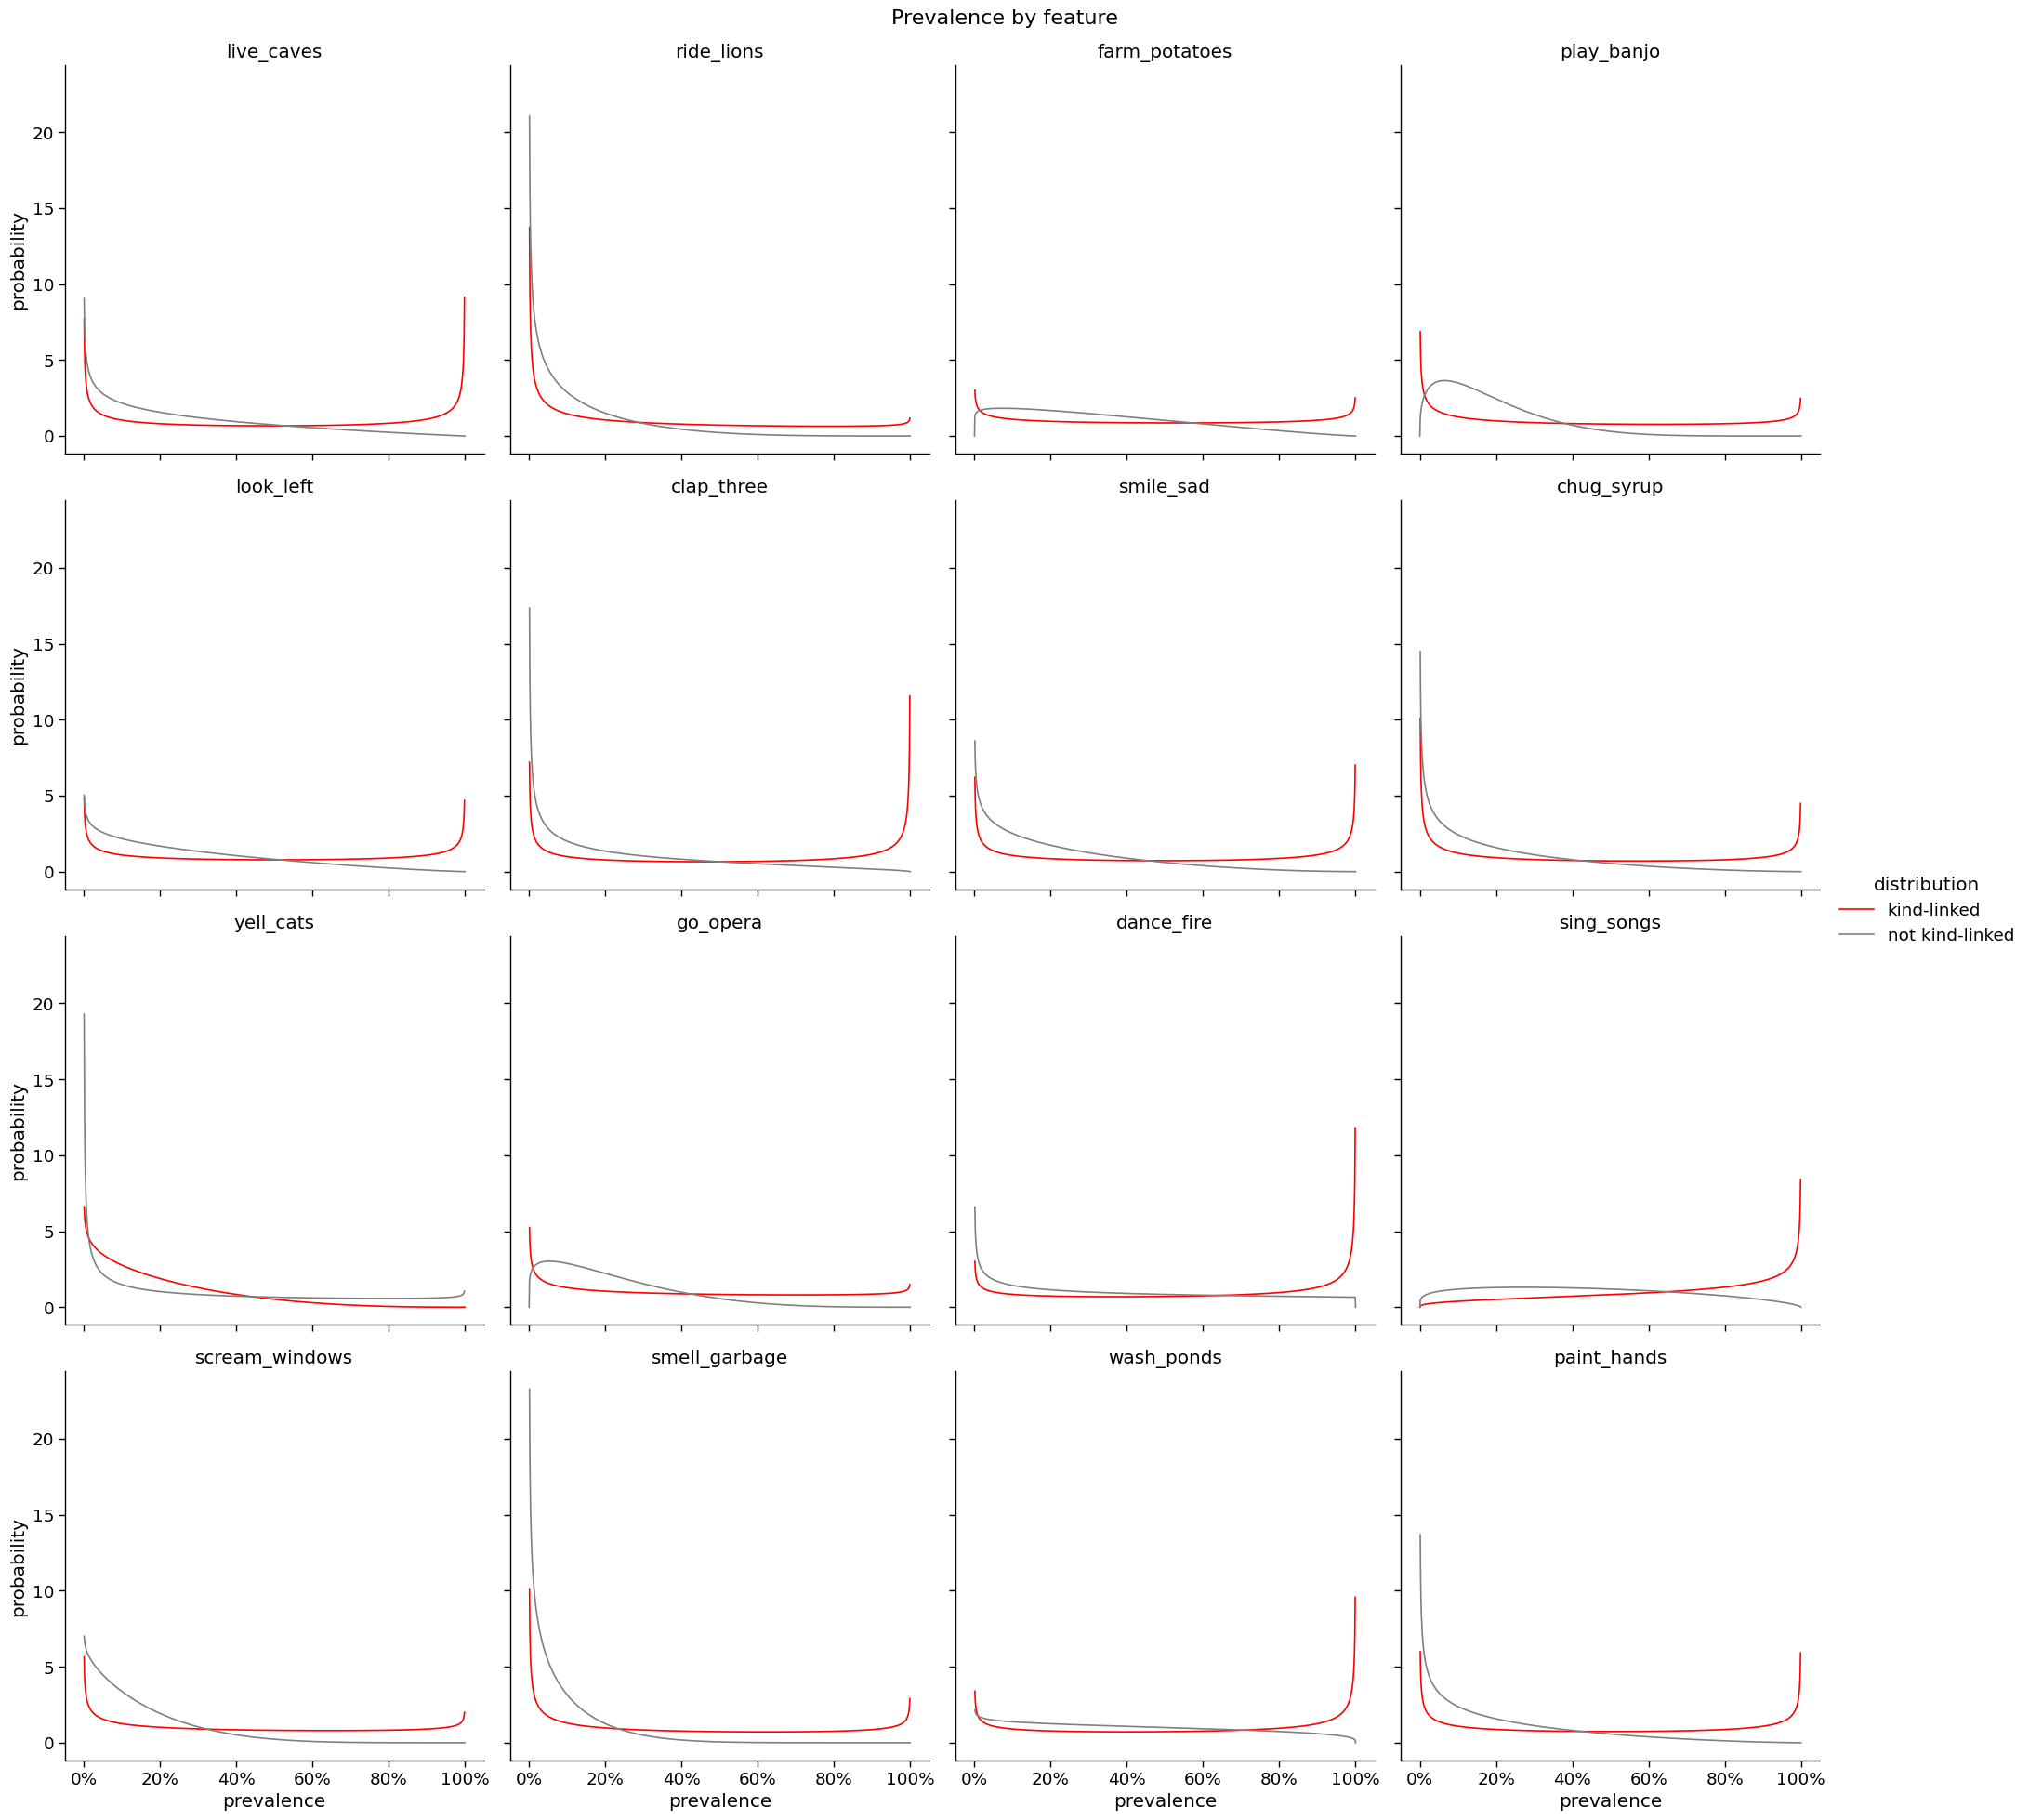

In [ ]:
# make plot
g = sns.relplot(data=features_prevalence, 
            x="prevalence", y="probability",
            hue="distribution", palette=["red", "gray"],
            col="feature", col_wrap=4,
            kind="line")
g.fig.suptitle('Prevalence by feature', fontsize=16)
# g.set_titles(col_template=feature_labels) # FIXME
g.set_titles(col_template="{col_name}")
g.fig.subplots_adjust(top=0.95)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
plt.savefig("figs/study 6/prevalence_by_feature.png", bbox_inches = "tight")

## Fitted model predictions

In [62]:
# sample from the model (simulate participants from the distribution)
# prevalence judgments from model (10*n) --> mean

data_simulated = []

# for each of 3 conditions...
for condition in ["generic", "baseline", "specific"]:
    # run 300 simulations (=~3x actual participants):
    for simulation in range(1, 301):
        # for each of 16 features...
        for i, row in mle_per_feature.iterrows():
            # construct beta distributions for the given feature
            feature_kind_linked_prevalence = Beta(row['feature_kind_linked_prevalence_alpha'], 
                                                row['feature_kind_linked_prevalence_beta'])
            feature_not_kind_linked_prevalence = Beta(row['feature_not_kind_linked_prevalence_alpha'], 
                                                    row['feature_not_kind_linked_prevalence_beta'])
        
            # simulate a response
            response = observe_response(
                condition = condition,
                prevalence = None, # irrelevant for simulating response
                feature_kind_linked_prevalence = feature_kind_linked_prevalence,
                feature_not_kind_linked_prevalence = feature_not_kind_linked_prevalence,
                simulate_response = True
            )
            
            # record results
            data_simulated.append({
                'condition': condition,
                'simulation': simulation,
                'feature': row['feature'],
                'prevalence': response
            })

df_simulated = pd.DataFrame(data_simulated)

# match real data by rounding, clipping prevalence to .01-.99, ordering condition and features
df_simulated['prevalence'] = df_simulated['prevalence'].round(2)
df_simulated["prevalence"] = df_simulated["prevalence"].replace(1, .99)
df_simulated["prevalence"] = df_simulated["prevalence"].replace(0, .01)
df_simulated["condition"] = df_simulated["condition"].astype(
    pd.CategoricalDtype(categories=["generic", "baseline", "specific"], ordered=True))
df_simulated = df_simulated.sort_values(by='feature') 

/var/folders/5p/8m9jqqdd581dvm8wc358jtz40000gp/T/ipykernel_32412/693698213.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels([feature_labels[x.get_text()] for x in g.get_xticklabels()])


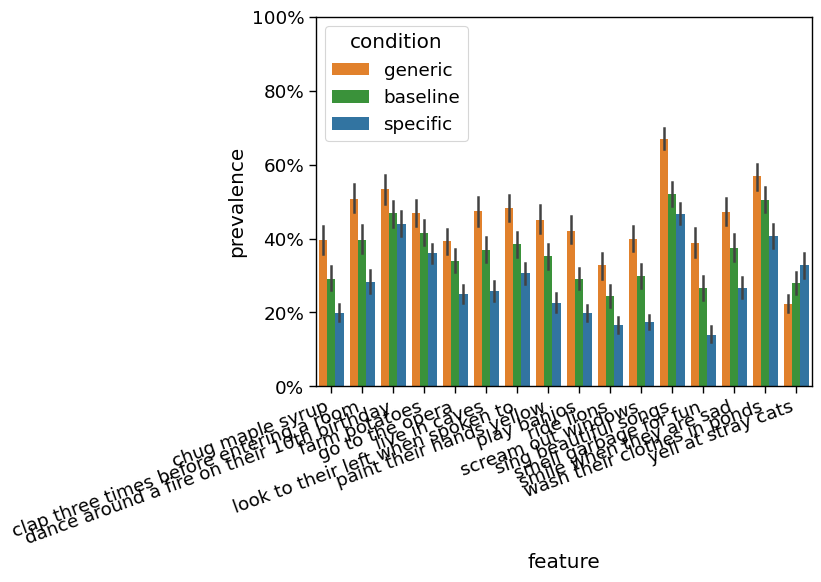

In [63]:
# plot simulated data
g = sns.barplot(df_simulated, 
                x="feature", y="prevalence", 
                hue="condition", palette=condition_colors)
# y-axis percentage 0-1
plt.ylim(0, 1)
g.yaxis.set_major_formatter(PercentFormatter(1))
# x-axis rotated long labels
g.set_xticklabels([feature_labels[x.get_text()] for x in g.get_xticklabels()])
plt.xticks(rotation=20, ha='right')

plt.savefig("figs/study 6/simulated_prevalence_by_feature_condition.png", bbox_inches = "tight")

## Fitted model vs data

In [64]:
# get means for each condition and feature
df_simulated_means = df_simulated.groupby(['condition', 'feature'], observed=True)['prevalence'].agg('mean').reset_index()
df_tidy_means = df_tidy.groupby(['condition', 'feature'], observed=True)['prevalence'].agg('mean').reset_index()
df_tidy_means = df_tidy_means.sort_values(by='feature')

In [65]:
# add source column
df_simulated_vs_real = pd.concat([df_tidy_means.assign(source='real_mean'),
                                  df_simulated_means.assign(source='simulated_mean')])

# pivot to wide, order condition
df_simulated_vs_real = df_simulated_vs_real.pivot(
    index=['condition', 'feature'],
    columns='source', values='prevalence').reset_index()

In [66]:
# calculate r^2
r2 = {'r': pearsonr(df_simulated_vs_real["real_mean"], df_simulated_vs_real["simulated_mean"]).statistic,
      'pvalue': pearsonr(df_simulated_vs_real["real_mean"], df_simulated_vs_real["simulated_mean"]).pvalue}
r2['r2'] = r2['r']**2
r2

{'r': np.float64(0.9056931706388048),
 'pvalue': np.float64(9.225066519198955e-19),
 'r2': np.float64(0.8202801193417713)}

In [67]:
# calculate r^2 by condition
r2_by_condition = []

for condition in ["generic", "baseline", "specific"]:
    df = df_simulated_vs_real[df_simulated_vs_real['condition'] == condition]
    r2_by_condition.append({'condition': condition,
                            'r': pearsonr(df["real_mean"], df["simulated_mean"]).statistic,
                            'pvalue': pearsonr(df["real_mean"], df["simulated_mean"]).pvalue})
    
r2_by_condition = pd.DataFrame(r2_by_condition)
r2_by_condition['r2'] = r2_by_condition['r']**2
r2_by_condition

,condition,r,pvalue,r2
0,generic,0.883123,0.000006,0.779907
1,baseline,0.861297,0.000018,0.741832
2,specific,0.857801,0.000021,0.735823


In [79]:
dict(zip(["generic", "baseline", "specific"], ["red"]))

{'generic': 'red'}

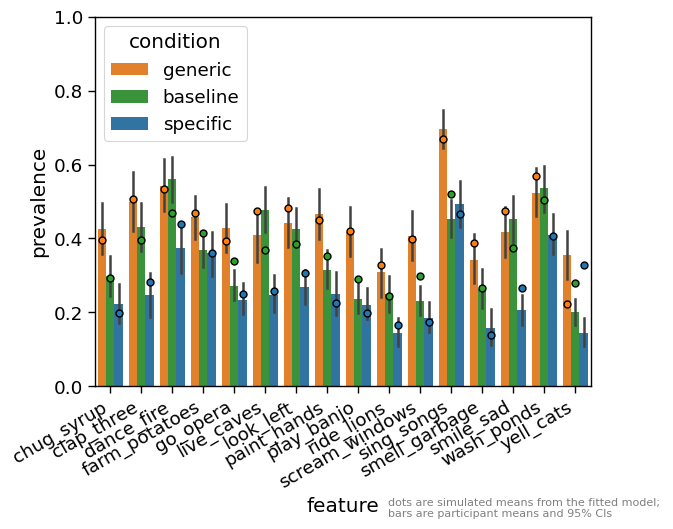

In [ ]:
# plot data vs simulated means
plt.figure()

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), dpi=300)

# simulated means
sns.stripplot(data = df_simulated_means, 
                x = 'feature', 
                y = 'prevalence',
                hue = 'condition', palette = condition_colors, dodge = True, legend = False,
                edgecolor = 'black', linewidth = 1)
                # zorder=10)

# data
sns.barplot(data = df_tidy,
            x = 'feature', order = sorted(df_tidy['feature']), # features in alphabetical order
            y = 'prevalence',
            hue = 'condition', palette = condition_colors)

# y-axis percentage 0-1
plt.ylim(0, 1)
# g.yaxis.set_major_formatter(PercentFormatter(1))
# g.yaxis.set_tick_params(labelsize = 11)
# # x-axis rotated long labels
# g.set_xticklabels([feature_labels[x.get_text()] for x in g.get_xticklabels()])
plt.xticks(rotation=30, ha='right')
# g.xaxis.set_tick_params(labelsize = 11)

# footnote
plt.annotate("dots are simulated means from the fitted model; \nbars are participant means and 95% CIs",
             xy=(0, 0), xytext=(200, -80),
             textcoords='offset points', ha='left', va='top',
             fontsize=8, color='gray')

plt.savefig("figs/study 6/data_condition_by_feature_w_sim_means.png", bbox_inches = "tight")
plt.show(g)

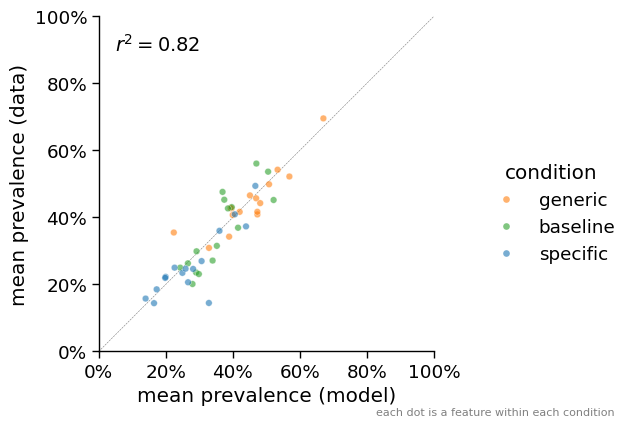

In [ ]:
# plot simulated vs real data
g = sns.relplot(df_simulated_vs_real, 
                x='simulated_mean', y='real_mean',
                hue='condition', palette=condition_colors, 
                kind='scatter', aspect=1,
                alpha=.6, zorder=10)
# y-axis percentage 0-1
plt.ylabel("mean prevalence (data)")
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
# x-axis percentage 0-1
plt.xlabel("mean prevalence (model)")
plt.xlim(0, 1)
plt.gca().xaxis.set_major_formatter(PercentFormatter(1))
# x=y line, square
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1,
                                               color='gray', linestyle='dashed',
                                               linewidth=.4))
plt.gca().set_aspect('equal')
# r^2
plt.text(.05, .95, 
         f"$r^2 = {r2['r2']:.2f}$",
         horizontalalignment='left',
         verticalalignment='top',
         fontsize=14)
# footnote
plt.annotate("each dot is a feature within each condition",
             xy=(0, 0), xytext=(200, -40),
             textcoords='offset points', ha='left', va='top',
             fontsize=8, color='gray')

plt.savefig("figs/study 6/simulated_vs_real_by_condition.png", bbox_inches = "tight")

In [313]:
df_simulated_vs_real

source,condition,feature,real_mean,simulated_mean
0,generic,chug_syrup,0.426316,0.438333
1,generic,clap_three,0.498526,0.516433
2,generic,dance_fire,0.541895,0.542933
3,generic,farm_potatoes,0.456737,0.491200
4,generic,go_opera,0.428105,0.398333
5,generic,live_caves,0.408526,0.463200
6,generic,look_left,0.442316,0.490967
7,generic,paint_hands,0.465368,0.478633
8,generic,play_banjo,0.416211,0.439267
9,generic,ride_lions,0.308737,0.347267


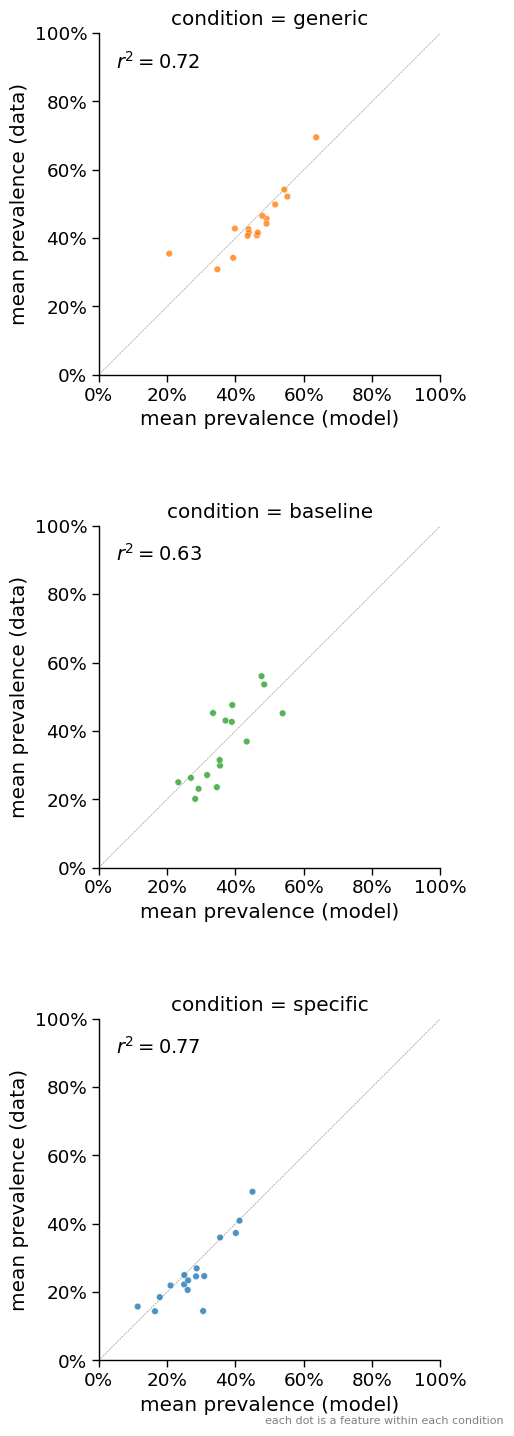

In [315]:
# plot simulated data
g = sns.relplot(df_simulated_vs_real, 
                x='simulated_mean', y='real_mean',
                hue='condition', palette=condition_colors, legend=False,
                row='condition', 
                kind='scatter', aspect=1,
                alpha=.8, zorder=10,
                facet_kws={'sharex': False}) # repeat x-axis across facets
# per facet
for ax in g.fig.axes:
    # square ratio
    ax.set_aspect('equal')
    # y-axis
    ax.set_ylabel("mean prevalence (data)")
    ax.set_ylim(0, 1)
    ax.yaxis.set_major_formatter(PercentFormatter(1))
    # x-axis
    ax.set_xlabel("mean prevalence (model)")
    ax.set_xlim(0, 1)
    ax.xaxis.set_major_formatter(PercentFormatter(1))
# x=y lines
g.map_dataframe(lambda data, **kws: plt.axline((0, 0), slope=1,
                                               color='gray', linestyle='dashed',
                                               linewidth=.4))
# r^2
for ax, annotation in zip(g.axes.flat, r2_by_condition['r2']):
    ax.text(.05, .95, 
            f"$r^2 = {annotation:.2f}$", 
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=14)
# footnote
plt.annotate("each dot is a feature within each condition",
             xy=(0, 0), xytext=(120, -40),
             textcoords='offset points', ha='left', va='top',
             fontsize=8, color='gray')

plt.savefig("figs/study 6/simulated_vs_real_by_condition.png", bbox_inches = "tight")